# Approximate q-learning

In this notebook you will teach a lasagne neural network to do Q-learning.

__Frameworks__ - we'll accept this homework in any deep learning framework. For example, it translates to TensorFlow almost line-to-line. However, we recommend you to stick to theano/lasagne unless you're certain about your skills in the framework of your choice.

In [1]:
%env THEANO_FLAGS='floatX=float32'
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

env: THEANO_FLAGS='floatX=float32'


In [2]:
import gym
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

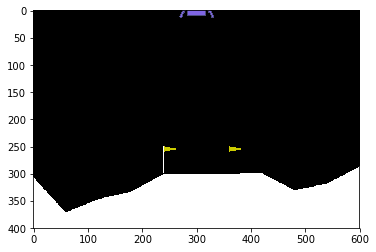

In [3]:
env = gym.make("LunarLander-v2")
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

# Approximate (deep) Q-learning: building the network

In this section we will build and train naive Q-learning with theano/lasagne

First step is initializing input variables

In [4]:
import theano
import theano.tensor as T

#create input variables. We'll support multiple states at once


current_states = T.matrix("states[batch,units]")
actions = T.ivector("action_ids[batch]")
rewards = T.vector("rewards[batch]")
next_states = T.matrix("next states[batch,units]")
is_end = T.ivector("vector[batch] where 1 means that session just ended")

In [5]:
from lasagne import nonlinearities

/Users/sergmiller/anaconda3/envs/py342/lib/python3.4/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [6]:
import lasagne
from lasagne.layers import *

#input layer
l_states = InputLayer((None,)+state_dim)

nnet = DenseLayer(l_states, 100, nonlinearity=nonlinearities.leaky_rectify)

#output layer
l_qvalues = DenseLayer(nnet,num_units=n_actions,nonlinearity=None)

#### Predicting Q-values for `current_states`

In [7]:
#get q-values for ALL actions in current_states
predicted_qvalues = get_output(l_qvalues,{l_states:current_states})

#predict q-values for next states
predicted_next_qvalues = get_output(l_qvalues,{l_states:next_states})

In [8]:
#compiling agent's "GetQValues" function
get_qvalues = theano.function([current_states], predicted_qvalues, allow_input_downcast=True)

In [9]:
#select q-values for chosen actions
predicted_qvalues_for_actions = predicted_qvalues[T.arange(actions.shape[0]),actions]

#### Loss function and `update`
Here we write a function similar to `agent.update`.

In [10]:
#Computing target q-values under 
gamma = 0.99
target_qvalues_for_actions = rewards + gamma * predicted_next_qvalues.max(axis=1)

#zero-out q-values at the end
target_qvalues_for_actions = (1-is_end)*target_qvalues_for_actions

#don't compute gradient over target q-values (consider constant)
target_qvalues_for_actions = theano.gradient.disconnected_grad(target_qvalues_for_actions)

In [11]:
#mean squared error loss function
loss = ((target_qvalues_for_actions - predicted_qvalues_for_actions)**2).mean()

In [12]:
#all network weights
all_weights = get_all_params(l_qvalues,trainable=True)

#network updates. Note the small learning rate (for stability)
updates = lasagne.updates.sgd(loss,all_weights,learning_rate=1e-4)

In [13]:
#Training function that resembles agent.update(state,action,reward,next_state) 
#with 1 more argument meaning is_end
train_step = theano.function([current_states,actions,rewards,next_states,is_end],
                             updates=updates,allow_input_downcast=True)

In [14]:
import numpy as np

### Playing the game

In [16]:
epsilon = 0.25 #initial epsilon

def generate_session(t_max=1000):
    """play env with approximate q-learning agent and train it at the same time"""
    
    total_reward = 0
    s = env.reset()
    
    for t in range(t_max):
        
        #get action q-values from the network
        q_values = get_qvalues([s])[0] 
        
        if np.random.random() < epsilon:
            a = np.random.randint(0, n_actions) 
        else:
            a = q_values.argmax()
            
        new_s,r,done,info = env.step(a)
        
        #train agent one step. Note that we use one-element arrays instead of scalars 
        #because that's what function accepts.
        train_step([s],[a],[r],[new_s],[done])
        
        total_reward+=r
        
        s = new_s
        if done: break
            
    return total_reward
        

In [ ]:
epsilon = 0.004
for i in range(100):
    
    rewards = [generate_session() for _ in range(100)] #generate new sessions
    
    epsilon*=0.95
    
    print ("mean reward:%.3f\tepsilon:%.5f"%(np.mean(rewards),epsilon))

    if np.mean(rewards) > 0:
        print ("You Win!")
        break
        
    assert epsilon!=0, "Please explore environment"

mean reward:-116.693	epsilon:0.00380
mean reward:-117.950	epsilon:0.00361
mean reward:-114.054	epsilon:0.00343
mean reward:-119.482	epsilon:0.00326
mean reward:-113.759	epsilon:0.00310
mean reward:-119.879	epsilon:0.00294


### Video

In [28]:
epsilon=0 #Don't forget to reset epsilon back to initial value if you want to go on training

In [28]:
env=gym.make("LunarLander-v2");env.reset();

In [26]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(env,directory="videos",force=True)
sessions = [generate_session() for _ in range(100)]
env.close()
#unwrap 
env = env.env.env
#upload to gym
#gym.upload("./videos/",api_key="<your_api_key>") #you'll need me later

#Warning! If you keep seeing error that reads something like"DoubleWrapError",


KeyboardInterrupt: 

In [40]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))
print(video_names)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[0])) #this may or may not be _last_ video. Try other indices

['openaigym.video.3.37347.video000008.mp4', 'openaigym.video.3.37347.video000027.mp4', 'openaigym.video.3.37347.video000000.mp4', 'openaigym.video.3.37347.video000001.mp4', 'openaigym.video.3.37347.video000064.mp4']
